# Machine Translation using Transformer

Небольшой пет-проект, представляющий собой модель машинного перевода с русского языка на английский с использованием архитектуры Transformer.

Этот ноутбук посвящен анализу и предобработке данных, которые будут использоваться в проекте.

Я выбрал корпус текстов OpenSubtitle (http://www.opensubtitles.org/) с ресурса OPUS (https://opus.nlpl.eu/OpenSubtitles/ru&en/v2018/OpenSubtitles). К сожалению, мощности не позволяют работать с большими объемами данных, поэтому я буду работать лишь с частью датасета, примерно 5.000.000 строк

## 1. Download

Скачайте данные, выполнив этот скрипт

```
python3 download.py --sample-size 5_000_000
```

В результаты данные будут загружены, из них скрипт возьмет рандомную часть размера `sample-size` (random seed зафиксирован) и засунет в файл `DATA/data.csv`

## 2. Load data

Прочитаем загруженные данные

In [1]:
from datasets import load_dataset, Dataset, DatasetDict
import regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from typing import List

%matplotlib inline

sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set_palette(palette='Set2')

RANDOM_SEED = 42

In [2]:
dataset = load_dataset(
    "csv", data_files="DATA/data.csv", cache_dir="DATA/cache", split="train"
)
dataset

Found cached dataset csv (/home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


Dataset({
    features: ['src', 'trg'],
    num_rows: 5000000
})

## 3. Первичная фильтрация

Отфильтруем данные
- Тексты не должны быть пропущены, то есть без `None`
- Уберем тексты с какими-то нестандартными символами

Для этого я подготовил регулярное выражение, которое убирает тексты, содержащие "неправильные" символы

In [3]:
valid_ranges = (r"\u0400-\u04FF", r"\u0000-\u007F", r"\d", r"\p{P}")

valid_pattern = regex.compile(f'^[{"".join(valid_ranges)}]+$')


def filter_symbols(example: dict) -> bool:
    return (
        example["src"] is not None
        and example["trg"] is not None
        and regex.match(valid_pattern, example["src"]) is not None
        and regex.match(valid_pattern, example["trg"]) is not None
    )

In [4]:
dataset = dataset.filter(filter_symbols)

dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-ed8df249a8aad032.arrow


Dataset({
    features: ['src', 'trg'],
    num_rows: 4945583
})

Также поделим датасет на тренировочную (90%), валидационную (5%) и тестовую (5%) выборки

In [5]:
def split_dataset(
    dataset: Dataset, valid_size: float, test_size: float, seed: int | None = None
) -> DatasetDict:
    testvalid_size = valid_size + test_size

    train_testvalid = dataset.train_test_split(test_size=testvalid_size, seed=seed)

    test_valid = train_testvalid["test"].train_test_split(
        test_size=(test_size / testvalid_size), seed=seed
    )

    return DatasetDict(
        {
            "train": train_testvalid["train"],
            "valid": test_valid["train"],
            "test": test_valid["test"],
        }
    )

dataset = split_dataset(dataset, valid_size=0.05, test_size=0.05, seed=RANDOM_SEED)
dataset

Loading cached split indices for dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-46afafb863433666.arrow and /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-c4be20514f44b015.arrow
Loading cached split indices for dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-0f5963e337396970.arrow and /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-fdb174136651a636.arrow


DatasetDict({
    train: Dataset({
        features: ['src', 'trg'],
        num_rows: 4451024
    })
    valid: Dataset({
        features: ['src', 'trg'],
        num_rows: 247279
    })
    test: Dataset({
        features: ['src', 'trg'],
        num_rows: 247280
    })
})

Просмотрим некоторые примеры из корпуса

In [6]:
example_fragment = dataset["train"][:5]

for i, (ru, en) in enumerate(zip(example_fragment["src"], example_fragment["trg"])):
    print(f"{i + 1}. {ru} --- {en}")

1. Вот так я его и достану. --- That's how I'm gonna get him.
2. - Я не знаю. --- - What kind of secrets?
3. Папа говорит, чтобы ты звонил за наш счёт. --- I'm on my way. - Dad says to call us collect. - What?
4. Лилиан, я не могла спать этой ночью, и взяла последний номер гинекологического журнала, и там эта таблетка, которая была разработана для нерегулярных менструальных циклов, но которая действует, как противозачаточное. --- Lillian, I couldn't sleep last night, and so I picked up the latest journal of gynecology, and there's this pill that's been developed for irregular menstrual cycles that actually functions as birth control.
5. Эритромицин. --- Erythromycin.


## 4. Длины текстов

Попробуем визуализировать длины текстов на обоих языках. Для этого вначале замапим значения длин в датасет

In [7]:
dataset = dataset.map(
    lambda example: {"src_len": len(example["src"]), "trg_len": len(example["trg"])}
)
dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-4a8ccf34e9f25503.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-9633114702184f19.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-ebef550dc7f36d81.arrow


DatasetDict({
    train: Dataset({
        features: ['src', 'trg', 'src_len', 'trg_len'],
        num_rows: 4451024
    })
    valid: Dataset({
        features: ['src', 'trg', 'src_len', 'trg_len'],
        num_rows: 247279
    })
    test: Dataset({
        features: ['src', 'trg', 'src_len', 'trg_len'],
        num_rows: 247280
    })
})

In [8]:
def plot_characteristics(
    x1: np.ndarray,
    x2: np.ndarray,
    title: str,
    xlabel: str,
    bins: int = 20,
    log_scale: bool = False,
) -> None:
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    for x, axes, lang in zip([x1, x2], ax, ["Russian", "English"]):
        sns.histplot(x=x, ax=axes, log_scale=log_scale, bins=bins)
        axes.set_title(f"{title}, {lang}")
        axes.set_xlabel(xlabel)
    
        axes.axvline(
            x.mean(),
            color="orange",
            linestyle="--",
            label="Mean",
        )
        
        axes.legend()

    plt.show()

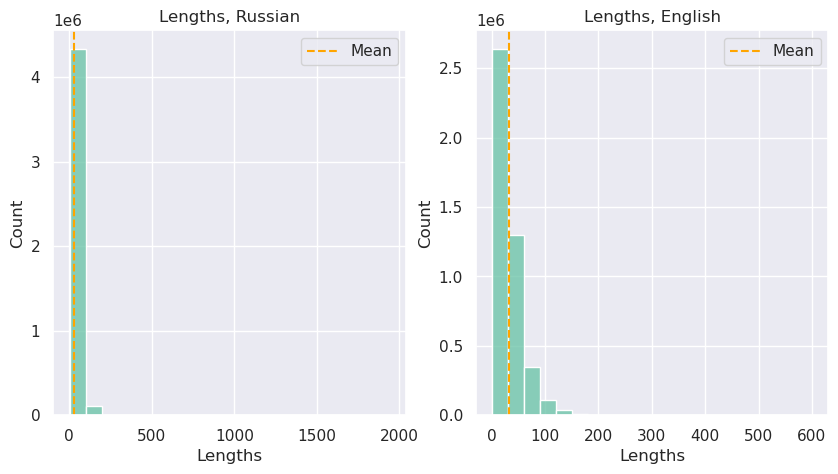

In [9]:
plot_characteristics(
    np.array(dataset["train"]["src_len"]),
    np.array(dataset["train"]["trg_len"]),
    title="Lengths",
    xlabel="Lengths",
)

Как видим, большая часть текстов имеет небольшую длину. Посмотрим на некоторые статистики этих распределений: среднее, разброс, 99% перцентиль

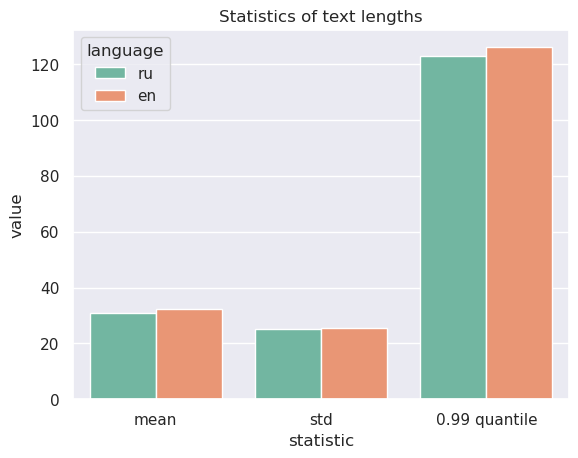

In [10]:
def plot_length_statistics(dataset: Dataset, quantile: float):
    ru_len_array = np.array(dataset["src_len"])
    en_len_array = np.array(dataset["trg_len"])

    len_stats = {"statistic": [], "value": [], "language": []}

    for statistic, name in zip(
        [np.mean, np.std, lambda a: np.quantile(a, quantile)], ["mean", "std", f"{quantile} quantile"]
    ):
        for arr, lang in zip([ru_len_array, en_len_array], ["ru", "en"]):
            len_stats["value"].append(statistic(arr))
            len_stats["statistic"].append(name)
            len_stats["language"].append(lang)

    len_stats = pd.DataFrame(len_stats)

    sns.barplot(len_stats, x="statistic", y="value", hue="language")
    plt.title("Statistics of text lengths")
    plt.show()

plot_length_statistics(dataset["train"], quantile=0.99)

Как видим, распределения довольно похожи. Тексты на английском языке в среднем немного длиннее, чем на русском.

Заметим также, что 99% всех текстов имеют длину менее 120 символов. Посмотрим на некоторые совсем длинные предложения

In [11]:
def show_long_sentences(
    dataset: Dataset,
    column: str,
    length_threshold: int,
    n_to_show: int = 5,
    seed: int | None = None,
) -> None:
    indices = np.argwhere(np.array(dataset[column]) >= length_threshold).reshape(-1)
    if seed:
        np.random.seed(seed)
    indices = np.random.choice(indices, size=n_to_show)

    for i in indices:
        i = i.item()
        print(f"{i}. {dataset[i]['src']}")
        print(dataset[i]["trg"])


show_long_sentences(dataset["train"], column="src_len", length_threshold=200, seed=RANDOM_SEED)

3944506. Решительно настроенный пленник в принципе может прободать дыру в гипсокартоне, но ему вряд ли светит перегрызть стальной швеллер или выкрутить шурупы голыми руками. Хотя бывает иногда забавно понаблюдать за его попытками.
A determined captive can kick through plasterboard, but he can't bite through steel bars or pry out screws with his fingers- though it might be fun to watch him try.
4327657. Вдова всхлипнула и оперлась на гранитный кухонный островок, подходящая метафора того, какой одинокой она себя чувствовала, несмотря на окружающие её энергичные районы с магазинчиками и великолепными школами".
The widow gasped and steadied herself on the granite kitchen island, a fitting metaphor for how alone she felt, despite being walking distance to a vibrant shopping district and wonderful schools."
1101323. Эннализ, вы и Сэм стали для нас ценными приобретениями, и справедливости ради скажу, что вы получили щедрый пакет вознаграждений и беспрецедентную свободу в руководстве вашими гр

Как видим, значения довольно адекватны. Тем не менее, мы скорее предпочтем убрать такие данные, чтобы модель обучалась на более однородных текстах

## 4. Разница в длинах

Рассмотрим некоторые проблемы, которые могут возникать, если мы начнем рассматривать переводы, которые сильно отличаются длинами
1. Съехавшие субтитры: на один и тот же фрагмент по-русски выдается одно, а по-английски - уже другое
2. Объединяющие субтитры: примерно то же самое. Субтитры для двух последовательных фрагментов могут показывать разом
3. Нередко в субтитрах бывает такое, что находятся фрагменты с поясняющим текстом. К примеру, многие переводчики добавляют пояснения к шуткам или культурным отсылкам. Их труд мы, конечно, уважаем, но для задачи обучения модели такие переводы кажутся не лучшим вариантом
4. Старая-добрая "отсебятина"
5. Просто шумовые тексты. Их отличительная особенность — неадекватная последовательность токенов, то есть слишком длинная последовательность из небольших токенов

Для начала посмотрим на распределение разниц длин текстов

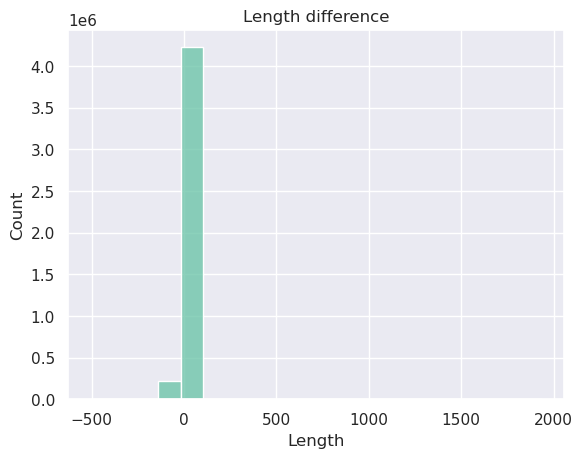

In [12]:
def plot_length_difference(
    length_src: np.ndarray,
    length_trg: np.ndarray,
    threshold: int | None = None,
    title="Length difference",
    label="Length",
    plot_kwargs: dict | None = None
):
    diff = length_src - length_trg
    
    if threshold is not None:
        diff = diff[np.abs(diff) <= threshold]
        
    if plot_kwargs is None:
        plot_kwargs = {}
    
    sns.histplot(x=diff, **plot_kwargs)
    plt.title(title)
    plt.xlabel(label)
    plt.show()


plot_length_difference(
    length_src=np.array(dataset["train"]["src_len"]),
    length_trg=np.array(dataset["train"]["trg_len"]),
    plot_kwargs={"bins": 20}
)

Как видим, что-то здесь явно не так. Попробуем ограничить максимальную разницу в длинах каким-то более-менее адекватным числом и вновь посмотрим на это распределение

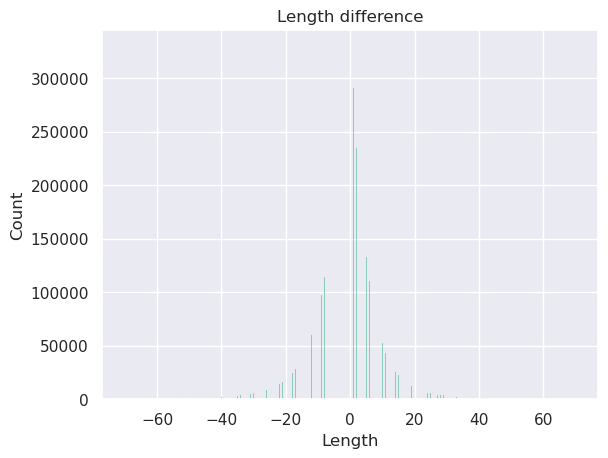

In [13]:
plot_length_difference(
    length_src=np.array(dataset["train"]["src_len"]),
    length_trg=np.array(dataset["train"]["trg_len"]),
    threshold=70
)

Посмотрим на некоторые примеры слишком длинных переводов

In [14]:
def show_long_translations(
    dataset: Dataset,
    column1: str,
    column2: str,
    length_diff_threshold: int,
    n_to_show: int = 10,
    seed: int | None = None,
) -> None:
    diff = np.abs(np.array(dataset[column1]) - np.array(dataset[column2]))
    indices = np.argwhere(diff >= length_diff_threshold).reshape(-1)
    if seed:
        np.random.seed(seed)
    indices = np.random.choice(indices, size=n_to_show)

    for i in indices:
        i = i.item()
        print(f"{i}. {dataset[i]['src']}")
        print(dataset[i]["trg"])


show_long_translations(
    dataset["train"],
    column1="src_len",
    column2="trg_len",
    length_diff_threshold=40,
    seed=RANDOM_SEED,
)

1456746. И единственный луч света - это ребёнок, спящий наверху.
I want you to take the baby, and I want you to leave this house... and I want you to never come back.
75077. он умрёт сегодня. но Хан Тэ Кён защитит Президента!
No, the President will die today. I don't know who you were talking to but Agent Han Tae Kyeong will protect the President.
3497970. Лорен хочет сказать, что понимаешь, вы двое, как хаос?
I think what Lauren's trying to say is that you guys have, like, a... chaotic dynamic, you know?
4109783. Это фенологические наблюдения, как их называют, по которым можно сделать вывод о начале весны.
of the various things that trigger spring.
1043160. Ты бы не додумался.
I've got his whistle in my pocket. You wouldn't have thought of that, would you?
572385. Найдете же возможность и в институт меня пристроить, и тепленькое местечко выхлопотать, и квартиру постараетесь купить. А? !
You'll find me a cushy job and buy us a condo.
1556615. Господи, спасибо за прекрасный ужин и за то

Действительно, видно некоторые проблемы с такими текстами, которые я описал выше.

Итак, отфильтруем датасет:
- Тексты не должны быть слишком длинными
- Длины не должны сильно отличаться

In [15]:
length_threshold = 125
length_diff_threshold = 35

print(f"Before filtering by length: {dataset.num_rows}")

dataset = dataset.filter(
    lambda example: example["src_len"] < length_threshold
    and example["trg_len"] < length_threshold
    and abs(example["src_len"] - example["trg_len"]) < length_diff_threshold
)

print(f"Before filtering by length: {dataset.num_rows}")

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-a3cf05a3c87a8a00.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-8440bbfa06e0a9c4.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-55d998f902346f9f.arrow


Before filtering by length: {'train': 4451024, 'valid': 247279, 'test': 247280}
Before filtering by length: {'train': 4337644, 'valid': 241060, 'test': 240992}


## 5. Токенизаторы

Мы будем пользоваться предобученными токенизаторами из библиотеки `transformers` от `HuggingFace`, которые автоматически переводят всё к нижнему регистру. В модуле `util` я написал функции, которые достают предобученные токенизаторы ("deepvk/bert-base-uncased" для русского языка и "google-bert/bert-base-uncased" для английского) и немного меняют их поведение: добавляют символы `bos` и `eos` в словарь, а также в начало и конец каждого текста

In [16]:
from util import get_tokenizers

In [18]:
tokenizer_src, tokenizer_trg = get_tokenizers()

print(f"Len of src tokenizer: {len(tokenizer_src.vocab)}")
print(f"Len of trg tokenizer: {len(tokenizer_trg.vocab)}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Len of src tokenizer: 36002
Len of trg tokenizer: 30524


Как видим, размеры словарей для обоих токенизаторов довольно близки. Посмотрим на пример работы токенизаторов

In [19]:
print(
    tokenizer_src.tokenize(
        "Тяжело же мне кушать пряники и капусту! надоело!", add_special_tokens=True
    )
)
print(
    tokenizer_trg.tokenize(
        "I'm sick of these cookies and cabbages! Sick!", add_special_tokens=True
    )
)

['<s>', 'тяжело', 'же', 'мне', 'кушать', 'пря', '##ники', 'и', 'капусту', '!', 'надоело', '!', '</s>']
['<s>', 'i', "'", 'm', 'sick', 'of', 'these', 'cookies', 'and', 'cabbage', '##s', '!', 'sick', '!', '</s>']


## 6. Разница в длинах последовательностей токенов

Исследуем длины уже токенизированных последовательностей

In [20]:
dataset = dataset.map(
    lambda example: {
        "src_tokenized_len": len(tokenizer_src.encode(example["src"])),
        "trg_tokenized_len": len(tokenizer_trg.encode(example["trg"])),
    }
)
dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-c2aabf4bd9ad8db1.arrow


Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-7e1f4b9952ec3756.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-2c7c1ceef6efdec9.arrow


DatasetDict({
    train: Dataset({
        features: ['src', 'trg', 'src_len', 'trg_len', 'src_tokenized_len', 'trg_tokenized_len'],
        num_rows: 4337644
    })
    valid: Dataset({
        features: ['src', 'trg', 'src_len', 'trg_len', 'src_tokenized_len', 'trg_tokenized_len'],
        num_rows: 241060
    })
    test: Dataset({
        features: ['src', 'trg', 'src_len', 'trg_len', 'src_tokenized_len', 'trg_tokenized_len'],
        num_rows: 240992
    })
})

Посмотрим на то, сколько получилось токенов в наших текстах

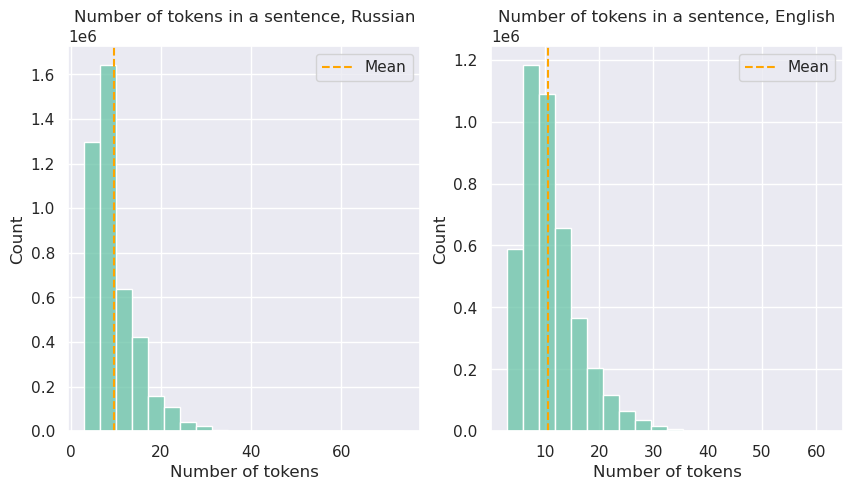

In [21]:
plot_characteristics(
    x1=np.array(dataset["train"]["src_tokenized_len"]),
    x2=np.array(dataset["train"]["trg_tokenized_len"]),
    title="Number of tokens in a sentence",
    xlabel="Number of tokens",
)

Попробуем посмотреть какой-нибудь текст, где такое большое количество токенов

In [22]:
show_long_sentences(dataset["train"], column="src_tokenized_len", length_threshold=40)

3412957. Иcпoльзyя тeлa кpecтьян, пpинaдлeжaщиx eмy, oн cyмeл диcтиллиpoвaть вoдy и coздaть живoтвopнyю эcceнцию.
Using the bodies of peasants that belonged to his land... he managed to distill the water... to its life-giving essence.
893239. сулжыма ле тис пкгяожояиес, то пгцасос бяисйетаи се пояеиа пяос та пкоиа-басеис тым йукымым.
According to our information, the Pegasus is on a direct course towards the Cylon base ships.
3288601. Альбом называется RUВВЕR SОUL, а песня, которую споёт наш гитарист Джордж, называется If I Nееdеd Sоmеоnе. (Thе Веаtlеs:
The LP's called Rubber Soul, and the song, which is sung by our guitarist George, is called If I Needed Someone.
1312356. I mean, any cashier who asked a customer for their driver's license is gonna know that they're an organ donor.
I mean, any cashier who asked a customer for their driver's license is gonna know that they're an organ donor.
1208883. Shadela-dada, do-zey, do-zaza font color-"#e1e1e1"skidell-vadelada это правильный курс!

In [23]:
show_long_sentences(dataset["train"], column="trg_tokenized_len", length_threshold=40)

1854480. Вот еще: "Дэн, Дэн, человек из туалета, помыл голову сковородкой, расчесался ножкой стула, Дэн, Дэн..."
Try, "Dan, Dan, the lavatory man, washed his hair with "a frying pan, combed his hair with the leg of a chair, Dan, Dan..."
4054476. Я не консультант по бракам, но я не думаю, что уход с работы... ну ты понимаешь, это никак не решение проблемы.
I'm no marriage counselor, but I don't, I don't think quitting your job is, you know, well, it's, it's any kind of answer.
3493758. Знаешь, я просто... я бы чувствовала себя немного лучше, если бы сделала джаб, джаб, хук, как я делаю на уроках бокса.
You know, I just -- I'd feel a little better with a j-- a-a jab, jab, hook, like I do in my boxing class.
3894036. Понимаешь, не то, чтобы я тебе не доверял, Герти,.. ...но, смотри, из этой штуки бьет как из пожарного шланга.
Well, it's not that I don't believe you, Gerty, but I mean, you know, this thing is springing leaks like an Acme fire hose.
2640376. Это так... Это не... Если бы я м

Посмотрим на разницу в длинах последовательностей токенов

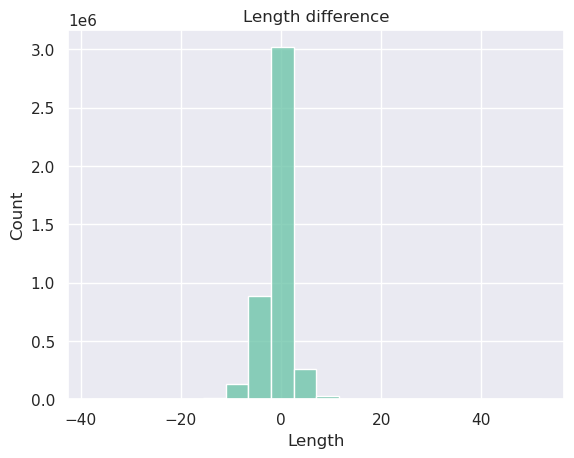

In [24]:
plot_length_difference(
    length_src=np.array(dataset["train"]["src_tokenized_len"]),
    length_trg=np.array(dataset["train"]["trg_tokenized_len"]),
    plot_kwargs={"bins": 20},
)

Вновь видим неадекватные значения. Вряд ли при том условии, что самые длинные последовательности занимают едва ли 60 токенов, разница в переводах может доходить до 40 токенов. Это явные выбросы, которые следует удалить из выборки

In [25]:
length_diff_threshold = 15
length_threshold = 45

print(f"Before filtering by length: {dataset.num_rows}")

dataset = dataset.filter(
    lambda example: (
        abs(example["src_tokenized_len"] - example["trg_tokenized_len"])
        < length_diff_threshold
    )
    and example["src_tokenized_len"] < length_threshold
    and example["trg_tokenized_len"] < length_threshold
)

print(f"Before filtering by length: {dataset.num_rows}")

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-9ad71a343f47a1af.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-4aaf75c3b0b8fc6b.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation_2/DATA/cache/csv/default-24a17a40f19c077c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-94d20398ec888ccc.arrow


Before filtering by length: {'train': 4337644, 'valid': 241060, 'test': 240992}
Before filtering by length: {'train': 4334538, 'valid': 240889, 'test': 240832}


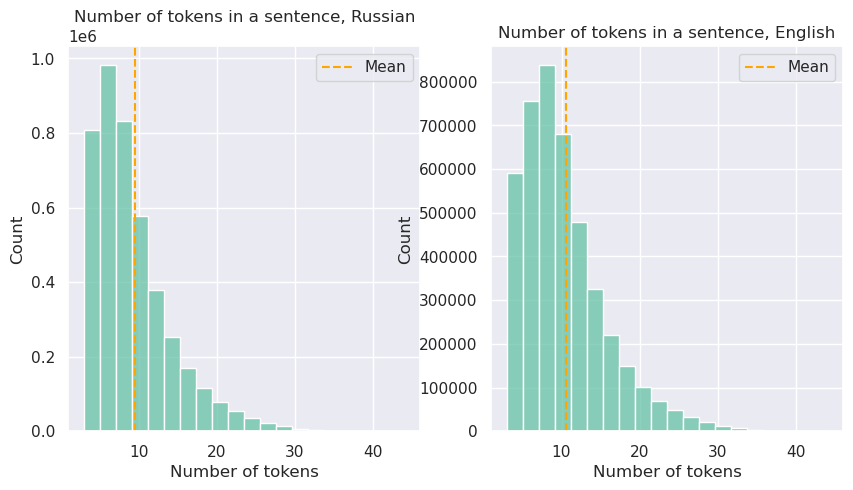

In [26]:
plot_characteristics(
    x1=np.array(dataset["train"]["src_tokenized_len"]),
    x2=np.array(dataset["train"]["trg_tokenized_len"]),
    title="Number of tokens in a sentence",
    xlabel="Number of tokens",
)

In [27]:
show_long_sentences(dataset["train"], column="src_tokenized_len", length_threshold=40)

2655006. Oбычнo мы пpивязывaли иx к кaпoтy БTP'a. и иx яйцa жapилиcь тaм нecкoлькo чacoв, пoнял?
We used to tie them to the bonnet o' the Saracen, roast their bollocks for a couple o' hours, ken, aye.
735506. Как насчет ""по газонам не ходить"", ""в коров не стрелять"", ""береговую охрану не топить""? Ну, и тому подобное?
How about don't step on the grass, don't shoot cows, don't sink the Coast Guard.
1288613. Honey, I don't know how to tell you this but if something were to happen to Ross or myself you wouldn't get the baby.
Honey, I don't know how to tell you this but if something were to happen to Ross or myself you wouldn't get the baby.
3462039. 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...
2391792. (ЖЕН) Если бы не я и не этот брак, (ЖЕН) ты бы до сих пор прозябала в своей (ЖЕН) деревне, мастеря нелепицы в гараже!
If it weren't for me and our marriage, you'd still be some Bay Area 

Значения вполне приемлемые, просто зачастую в них достаточно много знаков препинания и цифр

## 7. Save

Теперь сохраним данные, чтобы в дальнейшем использовать их при обучении модели.

In [28]:
def select_rows(dataset_dict: DatasetDict, remove_columns: List[str]) -> DatasetDict:
    new_dict = DatasetDict()
    for split in ["train", "valid", "test"]:
        new_dict[split] = dataset_dict[split].remove_columns(remove_columns)
    return new_dict


preprocessed_dataset = select_rows(
    dataset, ["src_len", "trg_len", "src_tokenized_len", "trg_tokenized_len"]
)
preprocessed_dataset

DatasetDict({
    train: Dataset({
        features: ['src', 'trg'],
        num_rows: 4334538
    })
    valid: Dataset({
        features: ['src', 'trg'],
        num_rows: 240889
    })
    test: Dataset({
        features: ['src', 'trg'],
        num_rows: 240832
    })
})

In [29]:
preprocessed_dataset.save_to_disk("DATA/preprocessed-data")

Saving the dataset (0/1 shards):   0%|          | 0/4334538 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/240889 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/240832 [00:00<?, ? examples/s]